# Chessboard Translation using Computer Vision

## Emmett Hintz, Tajveer Singh, Zach Amendola

### Install Libraries

In [55]:
!pip install pdf2image
!pip install opencv-python
!pip install tensorflow
!pip install keras
!apt-get update
!apt-get install -y poppler-utils
import os
from pdf2image import convert_from_path
import cv2
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,542 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,099 kB]
Fetched 4,898 kB in 2s (2,176 kB/s)
Reading package lists... Done
W: Skipping acquire of configur

### Load the data from Drive

In [56]:
boards_folder = "/content/drive/.shortcut-targets-by-id/1wTOsQdV3gYM-soXbe_TEppZIvVhdquEK/ML Project Files/Boards"
pdf_files = [f for f in os.listdir(boards_folder) if f.endswith(".pdf")]
print("Found PDF files:", pdf_files)

Found PDF files: ['board51.pdf', 'board28.pdf', 'board33.pdf', 'board39.pdf', 'board27.pdf', 'board34.pdf', 'board41.pdf', 'board44.pdf', 'board30.pdf', 'board50.pdf', 'board43.pdf', 'board45.pdf', 'board38.pdf', 'board46.pdf', 'board37.pdf', 'board29.pdf', 'board42.pdf', 'board36.pdf', 'board49.pdf', 'board31.pdf', 'board32.pdf', 'board48.pdf', 'board26.pdf', 'board35.pdf', 'board40.pdf', 'board47.pdf', 'board13.pdf', 'board8.pdf', 'board19.pdf', 'board18.pdf', 'board6.pdf', 'board2.pdf', 'board21.pdf', 'board17.pdf', 'board4.pdf', 'board7.pdf', 'board5.pdf', 'board22.pdf', 'board16.pdf', 'board10.pdf', 'board20.pdf', 'board25.pdf', 'board12.pdf', 'board14.pdf', 'board3.pdf', 'board23.pdf', 'board9.pdf', 'board1.pdf', 'board15.pdf', 'board24.pdf', 'board11.pdf', 'First 24 Chess dataset-part-1.pdf', 'First 24 Chess dataset-part-15.pdf', 'First 24 Chess dataset-part-13.pdf', 'First 24 Chess dataset-part-14.pdf', 'First 24 Chess dataset-part-10.pdf', 'First 24 Chess dataset-part-11.pdf',

### Process Data

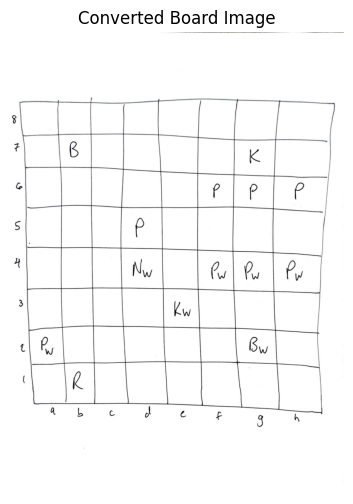

In [57]:
def pdf_to_image(pdf_path, dpi=200):
    """
    Convert the first page of a PDF to an image.
    Returns the image as a NumPy array (RGB).
    """
    pages = convert_from_path(pdf_path, dpi=dpi)
    # Use the first page
    image = np.array(pages[0])
    return image

# Test on one PDF file
example_pdf = os.path.join(boards_folder, pdf_files[11])
board_img = pdf_to_image(example_pdf)
# Optionally show the image (if using matplotlib)
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.imshow(board_img)
plt.title("Converted Board Image")
plt.axis("off")
plt.show()

In [58]:
# @title
def preprocess_board(image):
    """
    Convert to grayscale and apply any needed thresholding.
    Here we just convert to grayscale for simplicity.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Optional: apply adaptive thresholding or Canny edge detection if needed:
    # thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    #                                cv2.THRESH_BINARY, 11, 2)
    return gray

def segment_board(image, grid_size=8):
    """
    Assumes image is square. Slices the image into grid_size x grid_size squares.
    Returns list of 64 images.
    """
    h, w = image.shape[:2]
    square_size = h // grid_size   # assuming h==w
    squares = []
    for row in range(grid_size):
        row_squares = []
        for col in range(grid_size):
            square = image[row*square_size:(row+1)*square_size, col*square_size:(col+1)*square_size]
            row_squares.append(square)
        squares.append(row_squares)
    return squares

# Preprocess the board image and segment it
gray_board = preprocess_board(board_img)
squares = segment_board(gray_board)
print("Segmented board into", len(squares)*len(squares[0]), "squares.")

Segmented board into 64 squares.


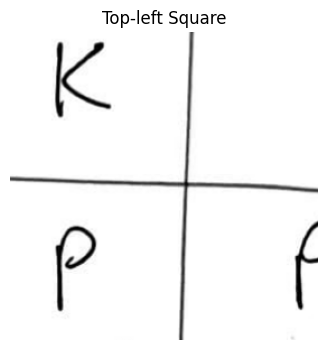

In [59]:
plt.figure(figsize=(4,4))
plt.imshow(squares[2][4], cmap='gray')
plt.title("Top-left Square")
plt.axis("off")
plt.show()

### Transfer Learning For Chess Piece Classification

In [64]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model

# Empty square, 12 pieces
num_classes = 13

# Load model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model for initial training

# Build your custom classifier on top of the base model
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 13)                  │           1,677 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,423,629 (9.25 MB)

 Trainable params: 165,645 (647.05 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [61]:
def classify_square(square_img, model, class_labels):
    """
    Preprocess the square image, run through the model, and return a predicted label.
    Here we assume that class_labels is a list mapping indices to FEN symbol strings (e.g., 'P', 'k', etc.)
    """
    # Resize to 224x224 and convert grayscale to RGB (repeat the channel)
    square_rgb = cv2.cvtColor(square_img, cv2.COLOR_GRAY2RGB)
    square_resized = cv2.resize(square_rgb, (224, 224))

    # Scale pixel values to [0,1]
    square_resized = square_resized.astype("float32") / 255.0
    # Expand dims for batch dimension
    input_tensor = np.expand_dims(square_resized, axis=0)

    # Run prediction (for now, using model.predict)
    pred = model.predict(input_tensor)
    pred_class = np.argmax(pred, axis=1)[0]
    return class_labels[pred_class]

# For demonstration, define dummy class labels.
class_labels = ["empty", "P", "N", "B", "R", "Q", "K",  # white pieces
                "p", "n", "b", "r", "q", "k"]           # black pieces

# For now, if the model is not trained, you could return "empty" always:
def dummy_classify(square_img):
    return "empty"

### Converting the 8×8 Prediction Grid to FEN


In [62]:
def convert_board_to_fen(predictions_matrix):
    """
    Convert an 8x8 list of predictions (each a string like 'p', 'N', or "empty")
    into a FEN string (only the placement part).
    """
    fen_rows = []
    for row in predictions_matrix:
        fen_row = ""
        empty_count = 0
        for cell in row:
            if cell == "empty":
                empty_count += 1
            else:
                if empty_count > 0:
                    fen_row += str(empty_count)
                    empty_count = 0
                fen_row += cell  # Ensure the cell value is already in FEN format
        if empty_count > 0:
            fen_row += str(empty_count)
        fen_rows.append(fen_row)
    fen = "/".join(fen_rows)
    return fen

In [63]:
def process_board_pdf(pdf_filename, model, class_labels):
    pdf_path = os.path.join(boards_folder, pdf_filename)
    print("Processing:", pdf_filename)

    # Convert PDF to image
    board_image = pdf_to_image(pdf_path)
    # Optionally, show the image
    # plt.imshow(board_image); plt.axis('off'); plt.show()

    # Preprocess (convert to grayscale)
    gray = preprocess_board(board_image)

    # Segment into 64 squares
    squares = segment_board(gray)

    # Classify each square, building an 8x8 prediction matrix
    predictions = []
    for row in squares:
        pred_row = []
        for square in row:
            # Use your classifier here:
            # predicted_piece = classify_square(square, model, class_labels)
            # For demonstration, use dummy classification:
            predicted_piece = dummy_classify(square)
            pred_row.append(predicted_piece)
        predictions.append(pred_row)

    # Convert to FEN
    fen = convert_board_to_fen(predictions)
    print("FEN for", pdf_filename, ":", fen)
    return fen

# Process all PDF files and store their FEN outputs
all_fens = {}
for pdf_file in pdf_files:
    fen = process_board_pdf(pdf_file, model, class_labels)
    all_fens[pdf_file] = fen

print("All FEN outputs:")
for pdf_file, fen in all_fens.items():
    print(f"{pdf_file}: {fen}")

Processing: board51.pdf
FEN for board51.pdf : 8/8/8/8/8/8/8/8
Processing: board28.pdf
FEN for board28.pdf : 8/8/8/8/8/8/8/8
Processing: board33.pdf
FEN for board33.pdf : 8/8/8/8/8/8/8/8
Processing: board39.pdf
FEN for board39.pdf : 8/8/8/8/8/8/8/8
Processing: board27.pdf
FEN for board27.pdf : 8/8/8/8/8/8/8/8
Processing: board34.pdf
FEN for board34.pdf : 8/8/8/8/8/8/8/8
Processing: board41.pdf
FEN for board41.pdf : 8/8/8/8/8/8/8/8
Processing: board44.pdf
FEN for board44.pdf : 8/8/8/8/8/8/8/8
Processing: board30.pdf
FEN for board30.pdf : 8/8/8/8/8/8/8/8
Processing: board50.pdf
FEN for board50.pdf : 8/8/8/8/8/8/8/8
Processing: board43.pdf
FEN for board43.pdf : 8/8/8/8/8/8/8/8
Processing: board45.pdf
FEN for board45.pdf : 8/8/8/8/8/8/8/8
Processing: board38.pdf
FEN for board38.pdf : 8/8/8/8/8/8/8/8
Processing: board46.pdf
FEN for board46.pdf : 8/8/8/8/8/8/8/8
Processing: board37.pdf
FEN for board37.pdf : 8/8/8/8/8/8/8/8
Processing: board29.pdf
FEN for board29.pdf : 8/8/8/8/8/8/8/8
Processi

KeyboardInterrupt: 